In [1]:
%reset -f
%matplotlib inline

In [4]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from scipy import stats


import datetime

In [5]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)

In [28]:
a = 4
b = 4

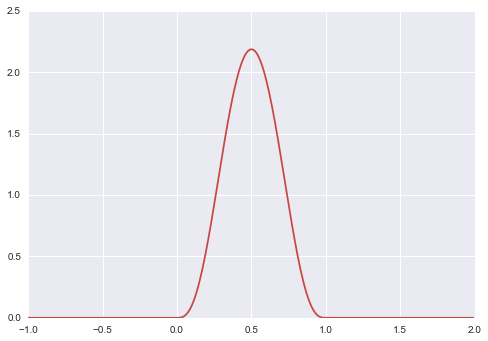

In [29]:
plt.plot(np.arange(-1,2,.01),stats.beta.pdf(np.arange(-1,2,.01), a, b))
plt.show()

In [91]:
dt = 0.001
tau = 0.01
t_pulse = 0.020
t_inter_min = 0.060
t_inter_max = 0.6
t_reset_min = 0.25
t_reset_max = 0.75
t_end_min = 0.1
t_end_max = 0.3
beta_width = 0.06

In [92]:
-1*np.ones(10)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [195]:
num_in = 2
num_out = 10

batch_size = 2
num_steps = 1000
dt = .001
def generate_data(trial_end_=-1*np.ones(batch_size), scale_=-1*np.ones(batch_size), start_=-1*np.ones(batch_size), interval_=-1*np.ones(batch_size)):
    """
    trial_end
    scale_
    start_
    
    """
    U = np.zeros((num_steps, batch_size, num_in))
    Y = np.zeros((num_steps, batch_size, num_out))
    time_=time
    for i in range(num_steps):
        for j in range(batch_size):
            if trial_end_[j] == -1 or np.abs(time_ - trial_end_[j])<=0.5*dt:
                # set up variables for this batch
                start_[j] = time_ + (t_reset_max - t_reset_min)*np.random.rand(1) + t_reset_min
                interval_[j] = (t_inter_max - t_inter_min)*np.random.rand(1) + t_inter_min
                scale_[j] = interval_[j]/t_inter_min
                trial_end_[j] = start_[j] + 2*interval_[j] + 0.5*beta_width*scale_[j]+(t_end_max - t_end_min)*np.random.rand(1) + t_end_min
            if time_ < start_[j]:
                U[i,j,0] = 1
            else:
                U[i,j,0] = 0
            if time_ > start_[j] + interval_[j] and time_ <= start_[j] + interval_[j] + t_pulse:
                U[i,j,1] = 1
            else:
                U[i,j,1] = 0
            for k in range(num_out):
                go = start_[j] + interval_[j] + (k+1)*interval_[j]/num_out
                scale = scale_[j]*(k+1)/num_out
                Y[i,j,k] = stats.beta.pdf((time_ - go)/(scale*beta_width)+0.5,4,4)/stats.beta.pdf(0.5,4,4)
        time_=time_+dt        

    return U, Y, trial_end_, scale_, start_, interval_

In [194]:
U_all = []
Y_all = []
for t in range(2):
    time = t*num_steps*dt
    if t == 0:
        U_out, Y_out, trial_end, scale, start, interval = generate_data()
    else:
        U_out, Y_out, trial_end, scale, start, interval = generate_data(trial_end_=trial_end, scale_=scale, start_=start, interval_=interval)
    U_all.append(U_out)
    Y_all.append(Y_out)

0.0
1.0


In [196]:
U_all_ = np.concatenate(U_all)
Y_all_ = np.concatenate(Y_all)

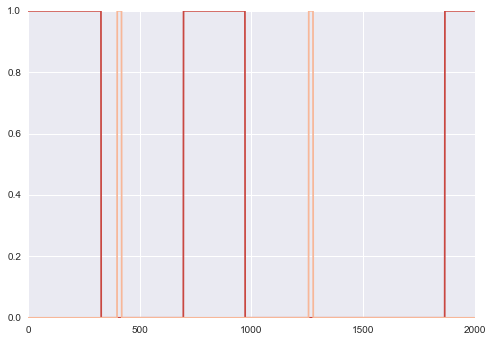

In [201]:
plt.plot(U_all_[:,0,:])
plt.show()

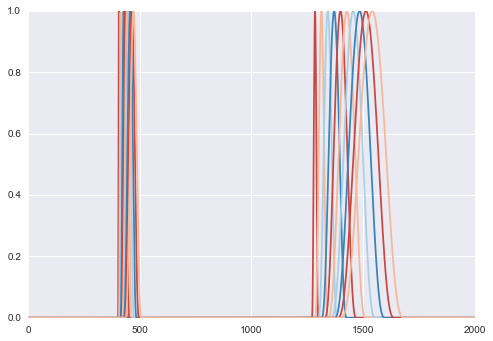

In [202]:
plt.plot(Y_all_[:,0,:])
plt.show()

## Set up input and output data for tensorflow

In [13]:
# # Some batch-related functions
# def hankelize(a, time_steps_):
#     """
#     Convert size (T,n) matrix to size (num_steps, T-num_steps+1 , n) tensor.
#     Different batches can now be selected by a[:,batch_inds,:].
#     """
#     dims = a.shape
#     T_new_ = dims[0] - time_steps_ + 1
#     b = np.zeros((T_new_, time_steps_) + dims[1:])
#     for i in range(T_new_):
#         b[i,:,:] = a[i:i+time_steps_, :]
#     inds = range(b.ndim)
#     inds[0], inds[1] = inds[1], inds[0]
#     b = np.transpose(b, inds) # |
#     return b

# def get_rand_batch(data_, batch_size_):
#     '''
#     args:
#     return:
#     '''
#     inds = np.random.choice(data_[0].shape[1], batch_size_)
#     for i in range(len(data_)):
#         data_[i] = data_[i][:,inds,:]
#     return inds, data_

# def get_next_batch(data_, batch_counter_):
#     """  """
#     batch_counter += 1
#     for i in range(len(data_)):
#         data_[i] = data_[i][:,inds,:]
#     return data_

## Build tensorflow graph

In [ ]:
class CTRNNCell(RNNCell):
  """The most basic RNN cell."""

  def __init__(self, num_units, input_size=None, activation=tanh, dt_tau=0.1):
    if input_size is not None:
      logging.warn("%s: The input_size parameter is deprecated." % self)
    self._num_units = num_units
    self._activation = activation
    self._dt_tau = dt_tau

  @property
  def state_size(self):
    return self._num_units

  @property
  def output_size(self):
    return self._num_units

  def __call__(self, inputs, state, scope=None):
    """Most basic RNN: output = new_state = activation(W * input + U * state + B)."""
    with vs.variable_scope(scope or type(self).__name__):  # "BasicRNNCell"
        J = tf.get_variable('J', [self._num_units, self._num_units], dtype=tf.float32, initializer=array_ops.random_normal_initializer)
        output = (1 - self._dt_tau)*[state] + self.dt_tau*(tf.matmul())
      output = self._activation(_linear([inputs, state], self._num_units, True))
    return output, output


In [495]:
tf.reset_default_graph()

n = 100 # n = 100 neurons

x0 = tf.Variable(tf.random_normal([batch_size,n], stddev=0.01), name='x0')

C = tf.Variable(tf.random_normal([n,p], stddev=1/np.sqrt(n)), name='C')
d = tf.Variable(tf.constant(0.01, shape=[1,p]), name='d')

B = tf.Variable(tf.random_normal([m,n], stddev=1/np.sqrt(n)), name='B')

U = tf.placeholder(tf.float32, [time_steps, None, m], name='U')
Y = tf.placeholder(tf.float32, [time_steps, None, p], name='Y')

U_ = tf.unpack(U)
U_ = [tf.matmul(U_[i], B) for i in range(time_steps)]
U_ = tf.pack(U_)

cell = tf.nn.rnn_cell.BasicRNNCell(n)
cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell,p)
#cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
output, state = tf.nn.dynamic_rnn(cell, U_, initial_state=x0, dtype=tf.float32, time_major=True)

#Y_hat = tf.unpack(output)
#Y_hat = [tf.matmul(Y_hat[i], C) + d for i in range(time_steps)]
#Y_hat = tf.pack(Y_hat)

#output_diff = tf.gather(output, range(1,time_steps))-tf.gather(output, range(0,time_steps-1))

#Get A matrix
with tf.variable_scope('RNN/BasicRNNCell/Linear', reuse=True):
    A = tf.get_variable('Matrix')
    b = tf.get_variable('Bias')

In [500]:
[tf.all_variables()[i].name for i in range(len(tf.all_variables()))]

[u'x0:0',
 u'C:0',
 u'd:0',
 u'B:0',
 u'RNN/BasicRNNCell/Linear/Matrix:0',
 u'RNN/BasicRNNCell/Linear/Bias:0',
 u'RNN/OutputProjectionWrapper/Linear/Matrix:0',
 u'RNN/OutputProjectionWrapper/Linear/Bias:0']

In [502]:
tf.all_variables()[-1].get_shape()

TensorShape([Dimension(36)])

In [ ]:
beta1 = 0.0
beta2 = 0.0
gamma = 0.0
cost = tf.reduce_mean((Y_hat - Y)**2)
+beta1*tf.nn.l2_loss(A)
+beta2*tf.nn.l2_loss(C) 
#+gamma*tf.nn.l2_loss(output_diff)
        
train_op = tf.train.AdamOptimizer(learning_rate=0.0001) # 0.0001 
# add gradient_noise? 
#grads_and_vars = train_op.compute_gradients(cost)
opt_op = train_op.minimize(cost)

In [ ]:
tf.scalar_summary('loss', cost)

tf.histogram_summary('A', A)
tf.histogram_summary('B', B)
tf.histogram_summary('b', b)
tf.histogram_summary('C', C)
tf.histogram_summary('d', d)
tf.histogram_summary('x0', x0)

merged_summary_op = tf.merge_all_summaries()

In [ ]:
saver = tf.train.Saver()
cur_run = monkey+'_'+str(datetime.datetime.now().strftime("%m%d-%H%M-%S"))
load_model_path = './saves/'+cur_run
save_model_path = './saves/'+cur_run

In [ ]:
print cur_run

## Train

In [ ]:
with tf.Session() as sess:
    summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs/'+cur_run, graph=sess.graph)
    sess.run(tf.initialize_all_variables())
    #saver.restore(sess, load_model_path) # comment out if not loading

    for i in range(2000):
        feed_dict = {Y: y_data, U: u_data}
        _, loss_val, summary_str = sess.run([opt_op, cost, merged_summary_op], feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)

        if i % 500 == 0:
            print 'iter:', '%04d' % (i), \
                  'Loss:', '{:.6f}'.format(loss_val)
            saver.save(sess, save_model_path)

    print 'iter:', '%04d' % (i), \
          'Loss:', '{:.6f}'.format(loss_val)
    saver.save(sess, save_model_path)

    print 'Finished'

    # simulate model
    y_tf, x_tf = sess.run([Y_hat, output], feed_dict=feed_dict)

In [ ]:
# def dehankelize(data_):
#     data_ = np.concatenate([data_[:,i,:] for i in range(data_.shape[1])])
#     data_ = np.reshape(data_, (data_.shape[0]/4, 4, data_.shape[1]), order='F')
#     data_ = np.transpose(data_, (0,2,1))
#     return data_

In [ ]:
# y_tf_ = dehankelize(y_tf)
# x_tf_ = dehankelize(x_tf)

## Plot fit quality

In [ ]:
rows = 4
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(20,20))
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg_[:,:,muscle], linewidth=2, alpha=1)
            ax[i,j].plot(y_tf[:,:,muscle],'--',linewidth=4, alpha=0.5)
            ax[i,j].set_title(str(muscle))
plt.show()

## RNN neuron PC plots

In [ ]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf[:,i,:] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf[:,i,:] for i in range(4)]))

In [ ]:
# plot PCs for the RNN state variable
make_pairgrid([np.dot(x_tf[:,i,:], pca_x.components_.T) for i in range(4)])

## RNN activations

In [ ]:
rows = 10
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x_tf[:,:,neuron])
        ax[i,j].set_title(str(neuron))
plt.show()

### export to stupid lab

In [ ]:
savestr = '/Users/jeff/Documents/MATLAB/CyclingTask/data/tf_'+cur_run+'.mat'
savemat(savestr, mdict={'X': x_tf})

In [37]:
blah = 'loadpath'

False